# An example of using EASYMORE with source netCDF files in irregualr shape 
## Remapping of SCDNA to subbasins of South Saskatchewan River at Medicine Hat, Alberta, Canada.

In [1]:
import xarray as xr
import urllib.request
import numpy as np
import pandas as pd
import os
from datetime import datetime
import time

pwd = '../../temporary/SCDNA/' # folder where downloaded SCDNA is save should be ending with '/'
file_name = 'SCDNA_v1.1.nc'

# create the path to the SCDNA file
if not os.path.isdir(pwd):
    os.mkdir(pwd)

# donwload the file if does not exists
outfile = pwd+file_name
if os.path.isfile(outfile):
    print('It seems the file exists; perhaps perviously downloaded; will skip downloading')
else:
    # download the file
    print('Downloading SCDNA; this may take a while ...')
    print('Downloading starts at: ', datetime.now())
    url = 'http://zenodo.org/record/3953310/files/SCDNA_v1.1.nc4?download=1'
    urllib.request.urlretrieve(url, outfile)
    print('Downloading ends at: ', datetime.now())

It seems the file exists; perhaps perviously downloaded; will skip downloading


In [2]:
# 
ds = xr.open_dataset(pwd+file_name)

#
dim_station = len(ds['nstn'][:])

#
station_info = pd.DataFrame(columns=['ID', 'station_name'], index=range(dim_station))
station_info ['ID']           = 0
station_info ['lat']          = 0.00
station_info ['lon']          = 0.00
station_info ['ele']          = 0.00
station_info ['has_prec']     = 0
station_info ['has_max_temp'] = 0
station_info ['has_min_temp'] = 0
station_info ['station_name'] = 'test'

# loop to get the station information into the dataframe
for i in np.arange(dim_station):
    array = np.array(ds['ID'][:,i])
    array = [str(s, encoding='UTF-8') for s in array]
    array = ''.join(array)
    station_info ['station_name'].iloc[i] = array
    station_info ['ID'].iloc[i] = i + 1
    station_info ['lat'].iloc[i] = ds.LLE[0,i]
    station_info ['lon'].iloc[i] = ds.LLE[1,i]
    station_info ['ele'].iloc[i] = ds.LLE[2,i]
    station_info ['has_prec'].iloc[i] = 1 - np.isnan(ds['prcp'][i,0]).astype(int)
    station_info ['has_max_temp'].iloc[i] = 1 - np.isnan(ds['tmax'][i,0]).astype(int)
    station_info ['has_min_temp'].iloc[i] = 1 - np.isnan(ds['tmin'][i,0]).astype(int)
    
#
print('Number of stations with precipitation data: '+str(station_info ['has_prec'].sum()))
print('Number of stations with maximum temprature data: '+str(station_info ['has_max_temp'].sum()))
print('Number of stations with minimum temprature data: '+str(station_info ['has_min_temp'].sum()))

#
print(station_info.head())

#
station_info.to_csv('../../temporary/SCDNA/station_info.csv')



/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Number of stations with precipitation data: 24615
Number of stations with maximum temprature data: 19611
Number of stations with minimum temprature data: 19604
   ID   station_name        lat         lon        ele  has_prec  \
0   1  ECCA001010066  48.869999 -123.279999   4.000000         1   
1   2  ECCA001010960  48.599998 -123.470001  38.000000         1   
2   3  ECCA001011467  48.580002 -123.419998  53.299999         1   
3   4  ECCA0010114F6  48.570000 -123.389999  38.000000         1   
4   5  ECCA001011500  48.939999 -123.739998  75.000000         1   

   has_max_temp  has_min_temp  
0             0             0  
1             0             0  
2             0             0  
3             0             0  
4             1             1  


In [2]:
ds = xr.open_dataset(pwd+file_name)
station_info = pd.read_csv('../../temporary/SCDNA/station_info.csv')

# create the date time series
DateTime = pd.date_range(start = str(ds.date[0].values),\
                         end   = str(ds.date[-1].values),\
                         freq  = '1D') # time

# save precipitation
idx = station_info.index[station_info ['has_prec'] == 1]
prcp = np.array(ds['prcp'].values)
prcp = prcp[idx,:]
prcp = prcp.transpose()
station_info_has_prec = list(station_info ['station_name'].loc[idx])
prcp = pd.DataFrame(data = prcp,    # values
                    index = DateTime,
                    columns = station_info_has_prec)
prcp = prcp.rename_axis(index='Date_Time')
years = np.unique(prcp.index.year)
years = [2000,2001] # commnet if all the years are needed to be created
for year in years:
    prcp_slice = prcp.loc[str(year):str(year)]
    prcp_slice.to_csv(pwd+'precipitation_'+str(year)+'.csv')
    


In [3]:
import sys
import netCDF4      as nc4
import pandas as pd
import xarray as xr
import numpy as np
def dataframe_tonetcdf_xarray (data_frame,
                               variable_name = None,
                               unit_of_variable = None,
                               variable_long_name = None,
                               station_info_data = None,
                               station_info_columns = None,
                               nc_file_name = None,
                               data_frame_DateTime_column = None): # array of lon values; numpy array
    """
    @ author:                  Shervan Gharari
    @ Github:                  https://github.com/ShervanGharari/EASYMORE
    @ author's email id:       sh.gharari@gmail.com
    @ license:                 GNU-GPLv3
    This function get a pandas dataframe of some values (all float + datetime string) and save them in a netcdf file
    ---------
    data_frame: pandas data_frame
    time_column: name of time column in the data_frame, string
    file_name: netcdf file to be saved, string
    varibale_name: varibale to be saved in the netcdf file, string
    unit_of_variable: unit of variable in the netcdf file, string
    variable_long_name: long name of variable in the netcdf file, string
    time_step = 'seconds', # minutes, hours, or days
    calendar = 'standard',
    ID  = None, # array of int values; numpy array
    lat = None, # array of lat values; numpy array
    lon = None, # array of lon values; numpy array
    names = None # list
    """
    
    if isinstance(data_frame, pd.DataFrame):
        print('EASYMORE detects that the input datafarame is pandas dataframe')
        if isinstance(data_frame.index, pd.DatetimeIndex):
            print('EASYMORE detects that index is pandas datatime')
        else:
            sys.exit('EASYMORE detects that the index is not datetime in data input file')
    elif isinstance(data_frame, str):
        if data_frame_DateTime_column is None:
            sys.exit('dataframe is provided as string csv file,'\
                     +'please provide the name of time index column')
        # read the data csv
        data_frame = pd.read_csv(data_frame)
        # convert the data time of the data_frame to index
        data_frame[data_frame_DateTime_column] = pd.to_datetime(data_frame[data_frame_DateTime_column], infer_datetime_format=True)
        data_frame = data_frame.set_index(data_frame_DateTime_column) # set as index
    else:
        sys.exit('The data input type is not recognized')
    data_frame = data_frame.rename_axis(index=None) # remove possible name of the index column
        
    #
    if station_info_data:
        if isinstance(station_info_data, pd.DataFrame):
            print('EASYMORE detects that the station data is pandas dataframe')
        elif isinstance(station_info_data, str):
            if data_frame_DateTime_column is None:
                sys.exit('dataframe is provided as string csv file, please'+\
                         ' provide the name of time index column')
            # read the data csv
            station_info_data = pd.read_csv(station_info_data)
        else:
            sys.exit('The station info data input type is not recognized')
        # check if all station info info is exsiting in the station info
        if set(list(data_frame.columns)) <= set(list(station_info_data [station_info_columns])):
            print('EASYMORE detects that the necessary information for the station are provided')
        else:
            sys.exit('EASYMORE detects the data frame provided for data, columns names, '+\
                    'are partly missing in the station information')
        # subset the station infromation for the provided data
        station_info_data = station_info_data [station_info_data[station_info_columns].isin(list(data_frame.columns))]
        data_frame = data_frame[list(station_info_data[station_info_columns])] # reorder columns to match station into    
    else:
        station_info_data = pd.DataFrame(data_frame.columns, columns=['station_name'])
    
    
    # assign n to index if index is None
    if station_info_data.index.name is None:
        station_info_data.index.name = 'n'
    
    #
    info = xr.Dataset(station_info_data.to_xarray())
    data = xr.Dataset(data_vars=dict(values=(["time", station_info_data.index.name],
                                                  np.array(data_frame))),
                      coords=dict(time = data_frame.index))
    if unit_of_variable:
        data['values']['units'] = unit_of_variable
    if variable_long_name:
        data['values']['long_name'] = variable_long_name
    if variable_name:
        data = data.rename_vars({'values':variable_name})
    
    #
    data = xr.merge([data, info])
    
    #
    if nc_file_name:
        os.system ('rm '+nc_file_name)
        data.to_netcdf(nc_file_name)
        
    return data


#
datat = dataframe_tonetcdf_xarray ('../../temporary/SCDNA/precipitation_2000.csv',
                    data_frame_DateTime_column = 'Date_Time',
                                  station_info_data = '../../temporary/SCDNA/station_info.csv',
                               station_info_columns = 'station_name',
                                  nc_file_name = '../../temporary/SCDNA/precipitation_2000.nc')


# 'precip',
#                     'precip',
#                     'precip',
#                     '../../temporary/SCDNA/station_info.csv',
#                     'station_name',
#                     nc_file_name = '../../temporary/SCDNA/precipitation_2000.nc',


print(datat)


ds1 = xr.open_dataset('../../temporary/SCDNA/precipitation_2000.nc')
print(ds1)

    

EASYMORE detects that the necessary information for the station are provided
<xarray.Dataset>
Dimensions:       (n: 24615, time: 366)
Coordinates:
  * n             (n) int64 0 1 2 3 4 5 ... 27268 27269 27271 27272 27273 27275
  * time          (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
Data variables:
    values        (time, n) float64 0.0 3.588 0.3947 0.0 0.0 ... 0.0 1.0 2.5 0.0
    Unnamed: 0    (n) int64 0 1 2 3 4 5 ... 27268 27269 27271 27272 27273 27275
    ID            (n) int64 1 2 3 4 5 6 ... 27269 27270 27272 27273 27274 27276
    station_name  (n) object 'ECCA001010066' 'ECCA001010960' ... 'MRUSW00022514'
    lat           (n) float64 48.87 48.6 48.58 48.57 ... 59.05 56.25 20.96 21.32
    lon           (n) float64 -123.3 -123.5 -123.4 ... -134.6 -156.7 -158.1
    ele           (n) float64 4.0 38.0 53.3 38.0 75.0 ... 26.2 3.7 73.2 16.5
    has_prec      (n) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    has_max_temp  (n) int64 0 0 0 0 1 0 1 0 

In [49]:
#
import glob
# loading EASYMORE
from easymore.easymore import easymore
import geopandas as gpd
import netCDF4 as nc4
import pandas as pd
from easymore.easymore import easymore
import xarray as xr
import numpy as np

# initializing EASYMORE object




def shp_from_irregular_nc (file_names,
                           var_lon,
                           var_lat,
                           var_ID = None,
                           var_station_name = None,
                           station_shp_file_name = None,
                           voronoi_shp_file_name = None,
                           buffer = 2,
                           crs=None,
                           tolerance= 0.000001):    
    
    # initialize easymore
    esmr = easymore()
    
    # read the file (or the first file)
    nc_names = glob.glob(file_names)
    ncid     = nc4.Dataset(nc_names[0])
    
    # create the data frame
    points = pd.DataFrame()
    points['lon'] = ncid.variables[var_lon][:]
    points['lat'] = ncid.variables[var_lat][:]
    points['ID_s'] = 1 + np.arange(len(points))
    points['ID_test'] = points['ID_s']
    if var_ID:
        points['ID_s'] = ncid.variables[var_ID][:]
        points['ID_test'] = points['ID_s']
    if var_station_name:
        points['station_name'] = ncid.variables[var_station_name][:]
    
    # check if two points fall on each other
    points['lon_next'] = np.roll(points['lon'],1)
    points = points.sort_values(by=['lat','lon'])
    points['lat_next'] = np.roll(points['lat'],1)
    points['ID_test_next'] = np.roll(points['ID_test'], 1)
    points['distance'] = np.power(points['lon_next']-points['lon'], 2)+\
                         np.power(points['lat_next']-points['lat'], 2)
    points['distance'] = np.power(points['distance'], 0.5)
    idx = points.index[points['distance']<tolerance]
    if not (idx.empty):
        print('EASYMORE detects that the lat lon values are for 2 or'+\
              'more points are identical given tolerance =',str(tolerance))
        print('ID of those are:')
        print(points['ID_s'].loc[idx].values)
    points['lat'].loc[idx]=points['lat'].loc[idx]+tolerance
    points['lon'].loc[idx]=points['lon'].loc[idx]+tolerance
    points = points.sort_values(by='ID_s')
    points = points.drop(columns=['lon_next','lat_next','ID_test','ID_test_next','distance'])
    
    # making points
    points = esmr.make_shape_point(points,
                                   'lon',
                                   'lat',
                                    point_shp_file_name = station_shp_file_name,
                                    crs = crs)
    
    #
    voronoi = esmr.voronoi_diagram(points,
                                   'lon',
                                   'lat',
                                   ID_field_name = 'ID_s',
                                   voronoi_shp_file_name = voronoi_shp_file_name,
                                   buffer = buffer)
    
    #
    return voronoi


voronoi = shp_from_irregular_nc ('../../temporary/SCDNA/precipitation_2000.nc',\
                                 'lon',\
                                 'lat',\
                                 var_ID = 'ID',
                                 var_station_name = 'station_name'    ,
                                 station_shp_file_name='../../temporary/SCDNA/station_point.shp',
                                 voronoi_shp_file_name='../../temporary/SCDNA/voronoi.shp',
                                 buffer = 5)


EASYMORE version 0.0.3 is initiated.
EASYMORE detects that the lat lon values are for 2 ormore points are identical given tolerance = 1e-06
ID of those are:
[26924 26926 27139 27032 27023 27014 27069 27039 27148 27026 26931 26930
 27048 26907]
no crs is provided for the point shapefiles; EASYMORE will allocate WGS84


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/easymore/easymore.py:1788: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp.to_file(point_shp_file_name)


crs from the point geopandas:  EPSG:4326


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/easymore/easymore.py:2299: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stations_buffert = stations.buffer(buffer) # add a buffer
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/easymore/easymore.py:2339: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  Thiessen.to_file(voronoi_shp_file_name)


In [ ]:
# [26907 26924 26926 26930 26931 27014 27023 27026 27032 27039 27048 27069
#  27139 27148]

# 26445

In [23]:
import sys
import netCDF4      as nc4
import pandas as pd
def dataframe_tonetcdf (data_frame,
                        varibale_name,
                        unit_of_variable,
                        variable_long_name,
                        station_info_data,
                        station_info_columns,
                        nc_file_name,
                        data_frame_DateTime_column = '',
                        missing_value = -9999.00,
                        time_step = 'seconds', # minutes, hours, or days
                        calendar = 'standard'): # array of lon values; numpy array
    """
    @ author:                  Shervan Gharari
    @ Github:                  https://github.com/ShervanGharari/EASYMORE
    @ author's email id:       sh.gharari@gmail.com
    @ license:                 GNU-GPLv3
    This function get a pandas dataframe of some values (all float + datetime string) and save them in a netcdf file
    ---------
    data_frame: pandas data_frame
    time_column: name of time column in the data_frame, string
    file_name: netcdf file to be saved, string
    varibale_name: varibale to be saved in the netcdf file, string
    unit_of_variable: unit of variable in the netcdf file, string
    variable_long_name: long name of variable in the netcdf file, string
    time_step = 'seconds', # minutes, hours, or days
    calendar = 'standard',
    ID  = None, # array of int values; numpy array
    lat = None, # array of lat values; numpy array
    lon = None, # array of lon values; numpy array
    names = None # list
    """
    
    if isinstance(data_frame, pd.DataFrame):
        print('EASYMORE detects that the input datafarame is pandas dataframe')
        if isinstance(data_frame.index, pd.DatetimeIndex):
            print('EASYMORE detects that index is pandas datatime')
        else:
            sys.exit('EASYMORE detects that the index is not datetime in data input file')
    elif isinstance(data_frame, str):
        if data_frame_DateTime_column == '':
            sys.exit('dataframe is provided as string csv file,'\
                     +'please provide the name of time index column')
        # read the data csv
        data_frame = pd.read_csv(data_frame)
        # convert the data time of the data_frame to index
        data_frame[data_frame_DateTime_column] = pd.to_datetime(data_frame[data_frame_DateTime_column], infer_datetime_format=True)
        data_frame = data_frame.set_index(data_frame_DateTime_column) # set as index
    else:
        sys.exit('The data input type is not recognized')
        
    # create the time varibale
    start_time_unit = str(data_frame.index[0])
    # get the time unit
    if   time_step.lower() in ['seconds','second','sec','s']:
        time_var = data_frame.index.to_series().diff()/np.timedelta64(1, 's')
        time_unit = 'seconds'
    elif time_step.lower() in ['minutes','minute','min','m']:
        time_var = data_frame.index.to_series().diff()/np.timedelta64(1, 'm')
        time_unit = 'minutes'
    elif time_step.lower() in ['hours','hour','hr','h']:
        time_var = data_frame.index.to_series().diff()/np.timedelta64(1, 'h')
        time_unit = 'hours'
    elif time_step.lower() in ['days','day','d']:
        time_var = data_frame.index.to_series().diff()/np.timedelta64(1, 'h')
        time_var = time_var / 24
        time_unit = 'days'
    else:
        sys.exit('The time_unit provided is not recognized.')
    # creating the time variable
    time_var[0] = 0 # set the inital time_step as zero (from NaN)
    time_var = np.array(time_var) # change to numpy arrary
    time_var = np.add.accumulate(time_var) # change to assumulated from first time step
    # check if time is in int or float
    temp =[not (i%1) for i in time_var ]
    temp = all(temp)
    if temp: # all int
        time_dtype_code = 'i4'
    else: # there is float
        time_dtype_code = 'f8'
    
    #
    if isinstance(station_info_data, pd.DataFrame):
        print('EASYMORE detects that the station data is pandas dataframe')
    elif isinstance(station_info_data, str):
        if data_frame_DateTime_column == '':
            sys.exit('dataframe is provided as string csv file, please'+\
                     ' provide the name of time index column')
        # read the data csv
        station_info_data = pd.read_csv(station_info_data)
    else:
        sys.exit('The station info data input type is not recognized')
    
    # check if the station name
    # station_name
    save_lat_lon = False
    if len (station_info_columns) in [1,3,4]:
        print('station name is provided with name ' + station_info_columns[0])
        station_info_data ['station_name'] =  station_info_data[station_info_columns[0]]
        station_info_data ['station_name'] =  station_info_data ['station_name'].astype(str)
    # ID
    if len (station_info_columns) in [4]:
        print('ID is provided with name ' + station_info_columns[3])
        station_info_data ['ID'] =  station_info_data[station_info_columns[3]]
    # lat and lon
    if len (station_info_columns) in [3,4]:
        print('lon and lat are provided '+ station_info_columns[1]+' '+station_info_columns[2])
        station_info_data ['lon'] =  station_info_data[station_info_columns[1]]
        station_info_data ['lat'] =  station_info_data[station_info_columns[2]]
        save_lat_lon = True
    # ID
    if not ('ID' in station_info_data.columns):
        print('ID is not provided, it will be provided')
        station_info_data ['ID'] =  1 + np.arange(len(station_info_data))
    # 
    if len (station_info_columns) not in [1,3,4]:
        sys.exit('The input has 0, 2 or larger than 4 input make '+\
                 'sure station name alone or together with lon lat and/or ID is provided')
    
    # check if all station info info is exsiting in the station info
    if set(list(data_frame.columns)) <= set(list(station_info_data ['station_name'])):
        print('EASYMORE detects that the necessary information for the station are provided')
    else:
        sys.exit('EASYMORE detects the data frame provided for data, columns names, '+\
                'are partly missing in the station information')
        
    # subset the station infromation for the provided data
    station_info_data = station_info_data [station_info_data['station_name'].isin(list(data_frame.columns))]
    data_frame = data_frame[list(station_info_data['station_name'])] # reorder columns to match station into
    
    print(station_info_data)
    print(data_frame)
                                                                  
    os.system('rm '+nc_file_name)
    # write the netcdf file
    with nc4.Dataset(nc_file_name, "w", format="NETCDF4") as ncid: # creating the NetCDF file
        # define the dimensions
        dimid_N = ncid.createDimension('n', len(data_frame.columns))  # limited dimensiton equal the number of hruID
        dimid_T = ncid.createDimension('time', None)   # unlimited dimensiton
        # Variable time
        time_varid = ncid.createVariable('time', time_dtype_code, ('time', ))
        # Attributes
        time_varid.long_name = 'time'
        time_varid.units = time_unit +' since '+start_time_unit  # e.g. 'days since 2000-01-01 00:00' should change accordingly
        time_varid.calendar = calendar
        time_varid.standard_name = 'time'
        time_varid.axis = 'T'
        time_varid[:] = time_var
        # variable to be saved
        data_varid = ncid.createVariable(varibale_name, 'f8', ('time', 'n'), fill_value = missing_value)
        data_varid.long_name = variable_long_name
        data_varid.units = unit_of_variable
        data_varid[:] = np.array(data_frame)
        # variable for name of the columns
        Station_ID_varid = ncid.createVariable('ID','i4',('n',), fill_value = missing_value)
        Station_ID_varid.long_name = 'ID'
        Station_ID_varid.units = '1'
        Station_ID_varid [:] =  np.array(station_info_data ['ID'].astype(int))
        # varibale for station ID
        Station_names_varid = ncid.createVariable('Station_name',str,('n',))
        Station_names_varid.long_name     = 'Station name'
        Station_names_varid.units         = '1'
        Station_names_varidcf_role        = 'timeseries_id'
        # Write data
        Station_names_varid [:] = np.array(station_info_data ['station_name'])
        # variable lat
        if save_lat_lon:
            # 
            lon_varid = ncid.createVariable('longitude','f8',('n',), fill_value = missing_value)
            lon_varid.long_name = 'longitude'
            lon_varid.units = 'degrees_east'
            lon_varid[:] = np.array(station_info_data ['lon'])
            #
            lat_varid = ncid.createVariable('latitude','f8',('n',), fill_value = missing_value)
            lat_varid.long_name = 'latitude'
            lat_varid.units = 'degrees_north'
            lat_varid[:] = np.array(station_info_data ['lat'])
        #
        ncid.Conventions = 'CF-1.6'
        ncid.Author  = 'The data were written by Shervan Gharari' #+ self.author_name
        ncid.License = 'MIT' #self.license
        ncid.History = 'Created ' + time.ctime(time.time())
        ncid.Source  = 'Case: ' #+self.case_name + '; remapped by script from library of Shervan Gharari (https://github.com/ShervanGharari/EASYMORE).'


# dataframe_tonetcdf (prcp_slice,
#                     'precip',
#                     'precip',
#                     'precip',
#                     station_temp,
#                     ['station_name'],
#                     'test.nc') # array of lon values; numpy array

dataframe_tonetcdf ('../../temporary/SCDNA/precipitation_2000.csv',
                    'precip',
                    'precip',
                    'precip',
                    '../../temporary/SCDNA/station_info.csv',
                    ['station_name','lon','lat','ID'],
                    '../../temporary/SCDNA/precipitation_2000.nc',
                    data_frame_DateTime_column = 'Date_Time') # array of lon values; numpy array

ds1 = xr.open_dataset('../../temporary/SCDNA/precipitation_2000.nc')

print(ds1)
print(ds1['Station_name'][0])

ParserError: day is out of range for month: 2000-12-32

In [22]:
ds_slice = ds1.sel(time='2000-02-29')
print(ds_slice)

<xarray.Dataset>
Dimensions:       (n: 24615)
Coordinates:
    time          datetime64[ns] 2000-02-29
Dimensions without coordinates: n
Data variables:
    precip        (n) float64 ...
    ID            (n) float64 ...
    Station_name  (n) object ...
    longitude     (n) float64 ...
    latitude      (n) float64 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by Shervan Gharari
    License:      MIT
    History:      Created Sat Jul 30 23:13:36 2022
    Source:       Case: 


EASYMORE version 0.0.3 is initiated.
no crs is provided for the point shapefiles; EASYMORE will allocate WGS84
             lat         lon     ID   station_name  \
0      48.869999 -123.279999      1  ECCA001010066   
1      48.599998 -123.470001      2  ECCA001010960   
2      48.580002 -123.419998      3  ECCA001011467   
3      48.570000 -123.389999      4  ECCA0010114F6   
4      48.939999 -123.739998      5  ECCA001011500   
...          ...         ...    ...            ...   
24610  38.383301  -81.833900  27270  MRUSC00467852   
24611  59.049999 -158.516693  27272  MRUSC00502457   
24612  56.247200 -134.644699  27273  MRUSC00507557   
24613  20.962500 -156.675293  27274  MRUSC00513317   
24614  21.316700 -158.066696  27276  MRUSW00022514   

                          geometry  
0      POINT (-123.28000 48.87000)  
1      POINT (-123.47000 48.60000)  
2      POINT (-123.42000 48.58000)  
3      POINT (-123.39000 48.57000)  
4      POINT (-123.74000 48.94000)  
...               

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_58687/1289618193.py:43: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file('../../temporary/SCDNA/points.shp')


NameError: name 'll' is not defined

In [5]:
import pandas as pd
import xarray as xr

data = [['tom', 10], ['nick', 15], ['juli', 14]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Name', 'n'])
df.index.rename('n', inplace=True)

print(df)



station_info_data = pd.DataFrame(df.columns, columns=['station_name'])
print(station_info_data)


ds11 = xr.Dataset(station_info_data.to_xarray())

print(ds11)

ll

print(np.array_equal(df.Name, df.Name.astype(int)))


print(np.array_equal(df.Age, df.Age.astype(int)))


#np.array_equal(df.v, df.v.astype(int))


   Name   n
n          
0   tom  10
1  nick  15
2  juli  14
  station_name
0         Name
1            n
<xarray.Dataset>
Dimensions:       (index: 2)
Coordinates:
  * index         (index) int64 0 1
Data variables:
    station_name  (index) object 'Name' 'n'


NameError: name 'll' is not defined

In [66]:
data_frame = '../../temporary/SCDNA/precipitation_2000.csv'
data_frame_DateTime_column = 'Date_Time'

# read the data csv
data_frame = pd.read_csv(data_frame)
# convert the data time of the data_frame to index
data_frame[data_frame_DateTime_column] = pd.to_datetime(data_frame[data_frame_DateTime_column], infer_datetime_format=True)
data_frame = data_frame.set_index(data_frame_DateTime_column) # set as index
print(data_frame)


            ECCA001010066  ECCA001010960  ECCA001011467  ECCA0010114F6  \
Date_Time                                                                
2000-01-01       0.000000       3.587791       0.394734            0.0   
2000-01-02       4.183021       5.079223       5.665169            4.2   
2000-01-03      16.544836      22.826930      21.884140           17.6   
2000-01-04       0.000000       0.163096       0.394734            0.2   
2000-01-05       0.000000       0.538177       0.371712            0.0   
...                   ...            ...            ...            ...   
2000-12-27       3.351326       0.175424       0.052376            0.0   
2000-12-28       0.000000       0.000000       0.000000            0.0   
2000-12-29       1.517003       2.723489       3.090596            4.2   
2000-12-30       2.626995       3.933598       2.630061            4.2   
2000-12-31       0.000000       0.479830       1.006588            0.8   

            ECCA001011500  ECCA001011

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


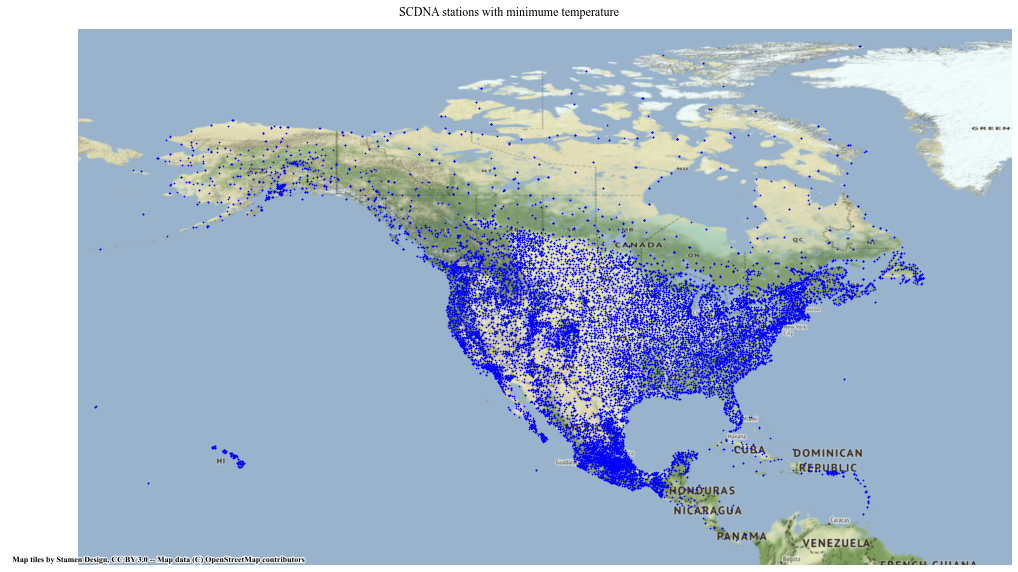

In [1]:
import xarray as xr
import pandas as pd
from   shapely.geometry import Point
import geopandas as gpd
import matplotlib
import os
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)


pwd = '/Users/shg096/Desktop/SCDNA/' # folder where downloaded SCDNA is save should be ending with '/'

infile_prcp  = pwd+'/prcp/SCDNA_v1.1.prcp.1979.nc'
outfile_prcp = pwd+'/prcp/SCDNA.prcp.gpkg'

infile_tmin  = pwd+'/tmin/SCDNA_v1.1.tmin.1979.nc'
outfile_tmin = pwd+'/tmin/SCDNA.tmin.gpkg'

infile_tmax  = pwd+'/tmax/SCDNA_v1.1.tmax.1979.nc'
outfile_tmax = pwd+'/tmax/SCDNA.tmax.gpkg'


def create_shp_SCDNA(infile, outfile):
    
    # load one the yearly nc files
    ds = xr.open_dataset(infile)
    
    nstn = ds.lat.shape[0] # number of stations

    points = pd.DataFrame()
    points['LATITUDE']  = ds.lat[:]
    points['LONGITUDE'] = ds.lon[:]
    points['ID']        = ds.stn[:]

    # the columns of the DataFrame
    points['geometry'] = points.apply(lambda row: Point(row.LONGITUDE, row.LATITUDE ), axis=1) # set the geometry
    points  = gpd.GeoDataFrame(points) # pass this to a geopandas dataframe
    points = points.set_crs("EPSG:4326") # set the projection to WGS 1984
    points.to_file(outfile)
    
create_shp_SCDNA(infile_prcp, outfile_prcp)
create_shp_SCDNA(infile_tmin, outfile_tmin)
create_shp_SCDNA(infile_tmax, outfile_tmax)



## visualizing the point shapefiles for precipitation stations
import contextily as ctx
import matplotlib.pyplot as plt

stations = gpd.read_file(outfile_tmin)

fig, ax = plt.subplots(figsize=(18, 10))
stations.plot(ax=ax, color='blue', markersize = 0.5)
ax.axis('off')
plt.axis('equal')
ctx.add_basemap(ax, zoom=4, crs='EPSG:4326')
#ctx.add_basemap(ax, zoom=4, crs=crs)

plt.title ('SCDNA stations with minimume temperature')
plt.savefig('../fig/Example3_A.png')
plt.show()




/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_71739/3774115355.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stations_buffert = stations.buffer(1) # add a buffer of 1 degree to the stations shapefile


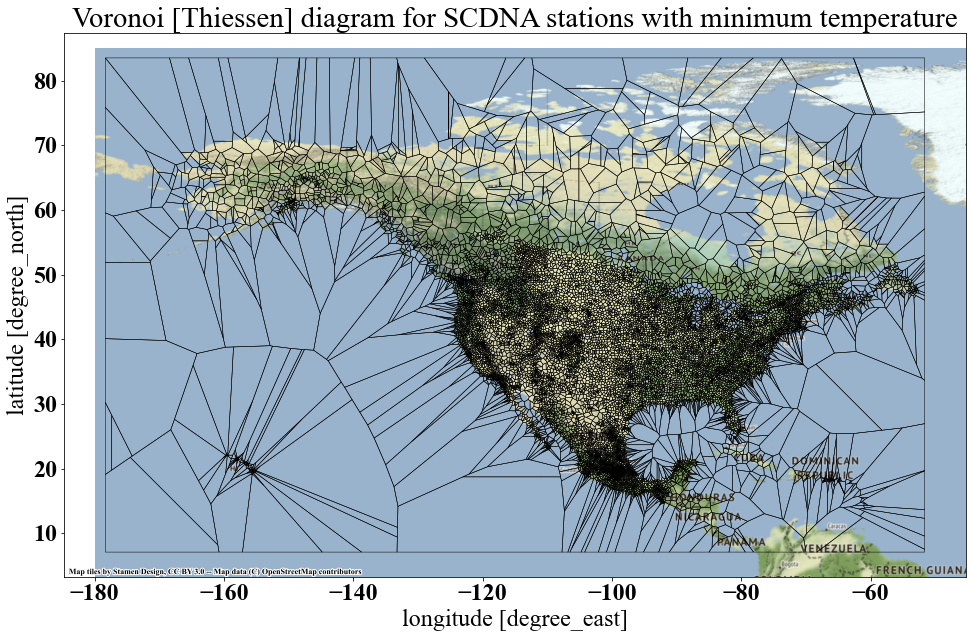

In [2]:
import shapefile
import geovoronoi
import os
from   shapely.geometry import Polygon
import numpy as np
import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)

infile_prcp  = pwd+'/prcp/SCDNA.prcp.gpkg'
outfile_prcp = pwd+'/prcp/SCDNA.prcp.voronoi.gpkg'

infile_tmin  = pwd+'/tmin/SCDNA.tmin.gpkg'
outfile_tmin = pwd+'/tmin/SCDNA.tmin.voronoi.gpkg'

infile_tmax  = pwd+'/tmax/SCDNA.tmax.gpkg'
outfile_tmax = pwd+'/tmax/SCDNA.tmax.voronoi.gpkg'


def voronoi_diagram(infile, outfile): # infile a point shapefile, outfile a shapefile
    
    # read the shapefile
    stations = gpd.read_file(infile)
    
    # get the total boundary of the shapefile
    stations_buffert = stations.buffer(1) # add a buffer of 1 degree to the stations shapefile
    minx, miny, maxx, maxy = stations_buffert.total_bounds
    
    # create the bounding shapefile
    parts = []
    with shapefile.Writer('test.shp') as w:
        w.autoBalance = 1 # turn on function that keeps file stable if number of shapes and records don't line up
        w.field("ID_bounding",'N') # create (N)umerical attribute fields, integer

        # creating the polygon given the lat and lon
        parts.append([ (minx, miny),\
                       (minx, maxy), \
                       (maxx, maxy), \
                       (maxx, miny), \
                       (minx, miny)])

        # store polygon
        w.poly(parts)

        # update records/fields for the polygon
        w.record(1)

    boundary = gpd.read_file('test.shp')
    os.remove('test.dbf');os.remove('test.shx');os.remove('test.shp')
    
    # create the voroni diagram for given point shapefile
    coords = geovoronoi.points_to_coords(stations.geometry)

    poly_shapes, location = \
    geovoronoi.voronoi_regions_from_coords(coords, boundary.iloc[0].geometry)
    
    
    # pass te polygons to shapefile
    Thiessen = gpd.GeoDataFrame()
    Thiessen['geometry'] = None
    Thiessen['ID'] = None
    Thiessen['LATITUDE'] = None
    Thiessen['LONGITUDE'] = None


    for i in np.arange(len(poly_shapes)):
        Thiessen.loc[i, 'geometry'] = Polygon(poly_shapes[i])
        Thiessen.loc[i, 'ID']       = stations.iloc[location[i][0]].ID.astype(float)
        Thiessen.loc[i, 'LATITUDE'] = stations.iloc[location[i][0]].LATITUDE.astype(float)
        Thiessen.loc[i, 'LONGITUDE']= stations.iloc[location[i][0]].LONGITUDE.astype(float)
    
    Thiessen = Thiessen.set_crs("EPSG:4326")

    Thiessen.to_file(outfile)
    
voronoi_diagram(infile_prcp, outfile_prcp)
voronoi_diagram(infile_tmin, outfile_tmin)
voronoi_diagram(infile_tmax, outfile_tmax)

## visualization of voronoi diagram for precipitation stations
shp = gpd.read_file(outfile_tmin)
fig, ax = plt.subplots(figsize=(18, 10))
shp.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 0.5 , figsize=(15,30),ax=ax)
ctx.add_basemap(ax, zoom=4, crs='EPSG:4326')
plt.title('Voronoi [Thiessen] diagram for SCDNA stations with minimum temperature')
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.savefig('../fig/Example3_B.png')


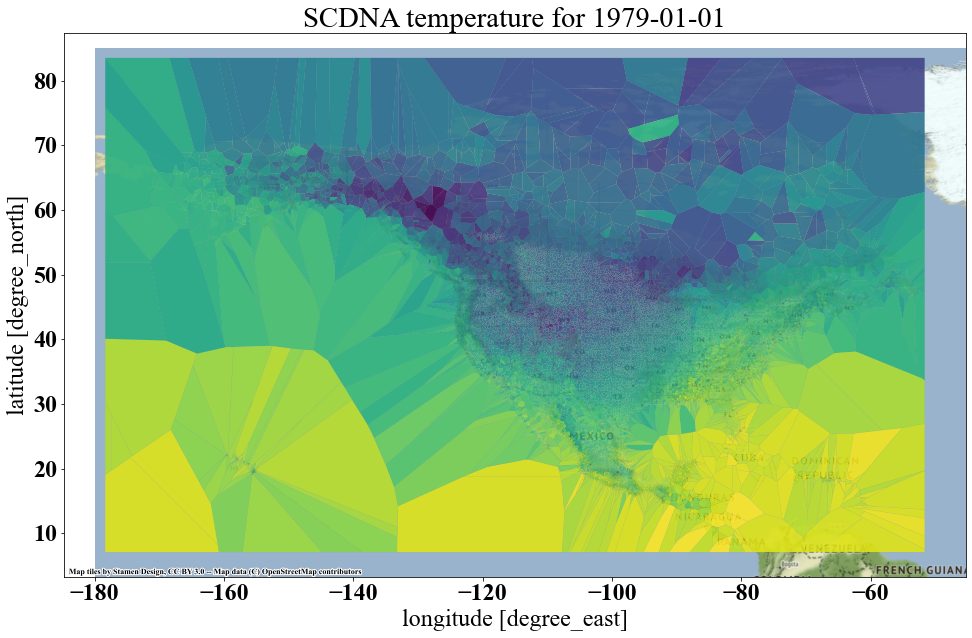

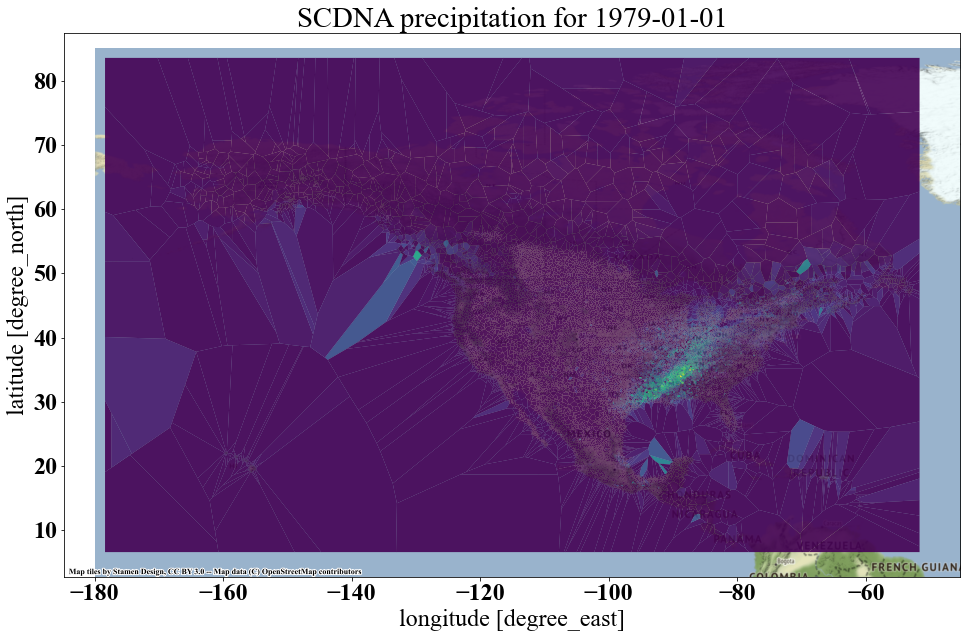

In [3]:
# visualize the voronoi diagram with data from SCDNA

voronoi_prcp = pwd+'/tmin/SCDNA.tmin.voronoi.gpkg'
infile_prcp  = pwd+'/tmin/SCDNA_v1.1.tmin.1979.nc'

#
Thiessen = gpd.read_file(voronoi_prcp)
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')

#
ds = xr.open_dataset(infile_prcp)
df = pd.DataFrame()
df ['values']     = ds.tmin.sel(time='1979-01-01')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)
df = df.sort_values(by='ID')# sort on values

# merge based on ID
Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='values', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.title('SCDNA temperature for 1979-01-01')
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.savefig('../fig/Example3_C.png')



# visualize the voronoi diagram with data from SCDNA
voronoi_prcp = pwd+'/prcp/SCDNA.prcp.voronoi.gpkg'
infile_prcp  = pwd+'/prcp/SCDNA_v1.1.prcp.1979.nc'

#
Thiessen = gpd.read_file(voronoi_prcp)
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')

#
ds = xr.open_dataset(infile_prcp)
df = pd.DataFrame()
df ['values']     = ds.prcp.sel(time='1979-01-01')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)
df = df.sort_values(by='ID')# sort on values

# merge based on ID
Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='values', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.title('SCDNA precipitation for 1979-01-01')
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.savefig('../fig/Example3_D.png')


In [4]:
# loading EASYMORE
from easymore.easymore import easymore

# initializing EASYMORE object
esmr = easymore()

# specifying EASYMORE needed arguments
esmr.case_name             = 'SCDNA_Medicine_Hat' # name of the case
esmr.temp_dir              = '../temporary/' # temporary path that the EASYMORE generated GIS files and rempped file will be saved
esmr.target_shp            = '../data/target_shapefiles/South_Saskatchewan_MedicineHat.shp' # target shapefile that the source will be remmaped to
esmr.source_nc             = '/Users/shg096/Desktop/SCDNA/tmin/SCDNA_*.nc' # name of netCDF file(s) if multiple you can specify with *
esmr.var_names             = ['tmin'] # name of variables from source netCDF file(s) to be remapped
esmr.var_lon               = 'lon' # name of varibale longitude in source netCDF files 
esmr.var_lat               = 'lat' # name of variable latitude in source netCDF files
esmr.var_time              = 'time' # name of varibale time in source netCDF file
esmr.source_shp            = '/Users/shg096/Desktop/SCDNA/tmin/SCDNA.tmin.voronoi.gpkg'
esmr.source_shp_lat        =  'LATITUDE' # name_of_nc_files
esmr.source_shp_lon        =  'LONGITUDE'
esmr.output_dir            = '../output/' # location where the remapped netCDF file will be saved
esmr.format_list           =  ['f4'] # format of the varibales to be saved with
esmr.fill_value_list       = ['-9999.00'] # missing values for the varibales
#esmr.remap_csv             = '../temporary/SCDNA_Medicine_Hat_remapping.csv' # if uncommneted EASYMORE will use this and skip GIS taskes

# execute EASYMORE
esmr.nc_remapper()



EASYMORE version 0.0.2 is initiated.
no author name is provide and the author name is changed to (author name)!
EASYMORE will remap variable  tmin  from source file to variable  tmin  in remapped NeCDF file
EASYMORE detects that target shapefile is in WGS84 (epsg:4326)
EASYMORE detects that no field for ID is provided in sink/target shapefile
arbitarary values of ID are added in the field ID_t
EASYMORE detects that either of the fields for latitude or longitude is not provided in sink/target shapefile
calculating centroid of shapes in WGS84 projection;
for better appximation use the easymore equal area centroid function to preprocess target shapefile
EASYMORE detects that no field for latitude is provided in sink/target shapefile
latitude values are added in the field lat_t
EASYMORE detects that no field for longitude is provided in sink/target shapefile
longitude values are added in the field lon_t


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]


it seems everything is OK with the sink/target shapefile; added to EASYMORE object target_shp_gpd
EASYMORE will save standard shapefile for EASYMORE claculation as:
../temporary/SCDNA_Medicine_Hat_target_shapefile.shp
EASYMORE detects that the varibales from the netCDF files are identicalin dimensions of the varibales and latitude and longitude
EASYMORE detects that all the varibales have dimensions of:
['stn', 'time']
EASYMORE detects that the longitude varibales has dimensions of:
['stn']
EASYMORE detects that the latitude varibales has dimensions of:
['stn']
EASYMORE detects case 3 - irregular lat/lon; shapefile should be provided
EASYMORE detects that no varibale for ID of the source netCDF file; an arbitatiry ID will be provided
EASYMORE detects that source shapefile is in WGS84 (epsg:4326)
The latitude and longitude in source NetCDF files are not unique
EASYMORE is creating the shapefile from the netCDF file and saving it here:
../temporary/SCDNA_Medicine_Hat_source_shapefile.shp

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site

------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /Users/shg096/Desktop/SCDNA/tmin/SCDNA_v1.1.tmin.1979.nc to ../output/SCDNA_Medicine_Hat_remapped_1979-01-01-00-00-00.nc
Started at date and time 2021-08-29 11:00:12.706179
Ended   at date and time 2021-08-29 11:00:14.916699
------
Remapping /Users/shg096/Desktop/SCDNA/tmin/SCDNA_v1.1.tmin.1980.nc to ../output/SCDNA_Medicine_Hat_remapped_1980-01-01-00-00-00.nc
Started at date and time 2021-08-29 11:00:14.956784
Ended   at date and time 2021-08-29 11:00:17.020299
------
Remapping /Users/shg096/Desktop/SCDNA/tmin/SCDNA_v1.1.tmin.1981.nc to ../output/SCDNA_Medicine_Hat_remapped_1981-01-01-00-00-00.nc
Started at date and time 2021-08-29 11:00:17.061588
Ended   at date and time 2021-08-29 11:00:19.076515
------


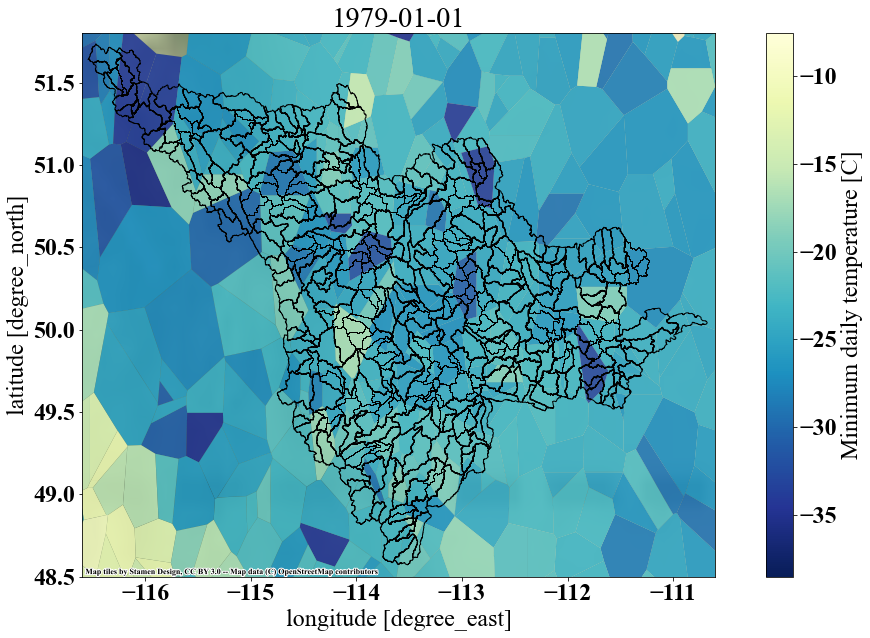

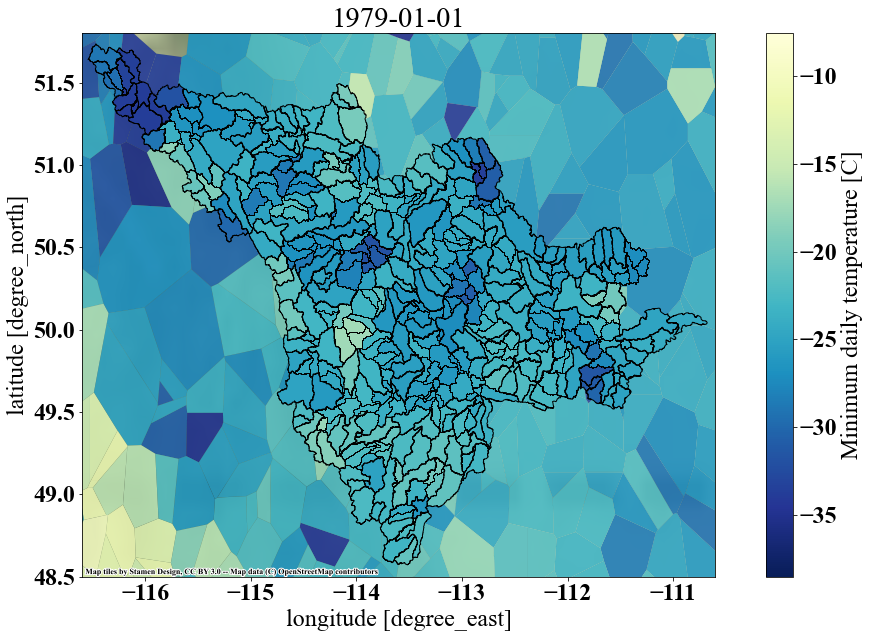

In [5]:
import glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as colors

import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)

ds = xr.open_dataset('/Users/shg096/Desktop/SCDNA/tmin/SCDNA_v1.1.tmin.1979.nc')
Thiessen = gpd.read_file('/Users/shg096/Desktop/SCDNA/tmin/SCDNA.tmin.voronoi.gpkg')
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')
shp_target = gpd.read_file(esmr.temp_dir+ esmr.case_name +\
                           '_target_shapefile.shp') # load the target shapefile
shp_target = shp_target.sort_values(by='ID_t')


#
df = pd.DataFrame()
df ['value']     = ds.tmin.sel(time='1979-01-10')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)


df = df.dropna() # drop the values that are NaN
df = df.sort_values(by='ID')# sort on values

Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

# subsetting
Thiessen = Thiessen[Thiessen['lat_nc']<52]
Thiessen = Thiessen[Thiessen['lat_nc']>48]
Thiessen = Thiessen[Thiessen['lon_nc']<-110]
Thiessen = Thiessen[Thiessen['lon_nc']>-120]

Thiessen = gpd.GeoDataFrame(Thiessen)

## visualization
norm = colors.Normalize(vmin=Thiessen.value.min(), vmax=Thiessen.value.max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='YlGnBu_r')

fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='value', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax, cmap='YlGnBu_r', legend=False)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.xlim([-116.6 , -110.6 ])
plt.ylim([48.5 , 51.8 ])
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.title('1979-01-01')
shp_target.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 1 , figsize=(15,30),ax=ax)

# add colorbar
ax_cbar = fig.colorbar(cbar, ax=ax)
# add label for the colorbar
ax_cbar.set_label('Minimum daily temperature [C]')
plt.savefig('../fig/Example3_E.png')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='value', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax, cmap='YlGnBu_r')
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.xlim([-116.6 , -110.6 ])
plt.ylim([48.5 , 51.8 ])
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.title('1979-01-01')


ds2 = xr.open_dataset('../output/SCDNA_Medicine_Hat_remapped_1979-01-01-00-00-00.nc')

shp_target ['value'] = ds2.tmin.sel(time='1979-01-10')

shp_target.plot(column='value', edgecolor='k',linewidth = 1 , figsize=(15,30),ax=ax,\
                legend=False, cmap='YlGnBu_r',\
                vmin = Thiessen.value.min(), vmax = Thiessen.value.max())

# add colorbar
ax_cbar = fig.colorbar(cbar, ax=ax)
# add label for the colorbar
ax_cbar.set_label('Minimum daily temperature [C]')
plt.savefig('../fig/Example3_F.png')
